In [1]:
import pandas as pd
import numpy as np
import sqlite3
from tqdm import tqdm
import pickle
from pandarallel import pandarallel
from time import time
from tokenizers import Tokenizer
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import scipy.sparse as sp
from goatools.obo_parser import GODag
from goatools.mapslim import mapslim
from goatools.gosubdag.gosubdag import GoSubDag
import requests
import os
import re
import itertools
import json

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.utils import resample
from collections import defaultdict
import random

from bertopic import BERTopic
from bertopic.backend import BaseEmbedder
from bertopic.cluster import BaseCluster
from bertopic.vectorizers import ClassTfidfTransformer
from bertopic.dimensionality import BaseDimensionalityReduction
from sklearn.preprocessing import LabelBinarizer, MultiLabelBinarizer
from sklearn.feature_extraction.text import CountVectorizer
from bertopic.representation import KeyBERTInspired

from typing import List, Dict, Tuple, Set, Any, Optional, Union

import networkx as nx

from vocabulary_functions import load_tokenizers
from go_functions import (
    create_unit_documents, create_go_labels, create_bertopic_model, 
    create_graph_aware_bertopic_model, split_data, evaluate_go_term_representations, 
    evaluate_go_term_representations_multilabel, compare_tokenization_methods, 
    optimize_graph_aware_parameters, visualize_comparison_results
)

In [2]:
# Initialize pandarallel for parallel processing
pandarallel.initialize(nb_workers=20, progress_bar=True)

INFO: Pandarallel will run on 20 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [3]:
# --- GO DAG and GO Slim Setup ---
ob_url = "http://purl.obolibrary.org/obo/go/go-basic.obo"
obo_path = "go-basic.obo"
if not os.path.exists(obo_path):
    with open(obo_path, "w") as f:
        f.write(requests.get(obo_url).text)
go_dag = GODag(obo_path)

goslim_url = "http://current.geneontology.org/ontology/subsets/goslim_generic.obo"
goslim_path = "goslim_generic.obo"
if not os.path.exists(goslim_path):
    with open(goslim_path, "w") as f:
        f.write(requests.get(goslim_url).text)
goslim_dag = GODag(goslim_path)
goslim_terms = set(goslim_dag.keys())
go_subdag_slim = GoSubDag(goslim_terms, go_dag)
goslim_id2name = {go_id: go_dag[go_id].name for go_id in goslim_terms}
goslim_name2id = {go_dag[go_id].name: go_id for go_id in goslim_terms}

go-basic.obo: fmt(1.2) rel(2025-03-16) 43,544 Terms
goslim_generic.obo: fmt(1.2) rel(go/2025-03-16/subsets/goslim_generic.owl) 206 Terms
 GoSubDag: 206 sources in 335 GOs rcnt(True). 65 alt GO IDs
 GoSubDag: namedtuple fields: NS level depth GO alt GO_name dcnt D1 id
 GoSubDag: relationships: set()


In [9]:
# --- Tokenizer and Vocabulary Configuration ---
vocab_sizes = [1600, 3200, 6400, 12800, 25600]
uniref_id = "50"

tokenizer_opts_list = [
    {
        'is_mut': False,
        'dataset': f'uniref{uniref_id}',
        'is_pretokenizer': False,
        'subs_matrix': 'blosum62',
        'mutation_cutoff': 0.7,
        'min_mutation_freq': 0.05,
        'min_mutation_len': 3,
        'max_mutation_len': 12,
        'vocab_size': vocab_sizes
    },
    {
        'is_mut': True,
        'dataset': f'uniref{uniref_id}',
        'is_pretokenizer': False,
        'subs_matrix': 'blosum62',
        'mutation_cutoff': 0.7,
        'min_mutation_freq': 0.05,
        'min_mutation_len': 3,
        'max_mutation_len': 12,
        'vocab_size': vocab_sizes
    },
    {
        'is_mut': True,
        'dataset': f'uniref{uniref_id}',
        'is_pretokenizer': True,
        'subs_matrix': 'pam70',
        'mutation_cutoff': 0.7,
        'min_mutation_freq': 0.05,
        'min_mutation_len': 3,
        'max_mutation_len': 12,
        'vocab_size': vocab_sizes
    },
]

tokenizer_list = load_tokenizers(tokenizer_opts_list, 'hf')
inner_vocab_list = load_tokenizers(tokenizer_opts_list, 'vocab')

vocab_list = {name: list(set(tok.get_vocab().keys())) for name, tok in tokenizer_list.items()}
methods = [name[:-len(str(vocab_sizes[0]))-1] for name in list(tokenizer_list.keys())[::len(vocab_sizes)]]
methods2names = {mn: mn.replace('mut', 'evo').replace('std', '').replace('blosum', 'BLOSUM').replace('pam', 'PAM').replace('pre', 'Pre') for mn in methods}
methods2names = {k: ' '.join(v.split()[:-2]) if 'evoBPE' in v else v for k, v in methods2names.items()}

In [10]:
# --- Vocabulary Lineage Construction ---
vocab_lineage_list = {}
for k, v in inner_vocab_list.items():
    vocab_lineage_list[k] = {token: {
        'frequency': -1, 'order': -1, 'parent_pair': [], 'parent_mutation': "",
        'parent_mutation_similarity': -1, 'partner_pair_self': False,
        'partner_pair_left': [], 'partner_pair_right': [], 'child_pair': [], 'child_mutation': []
    } for token in v.keys()}

for method_name, vocab in tqdm(inner_vocab_list.items(), desc="Building Vocabulary Lineage"):
    for token, inner_elements in vocab.items():
        lineage = vocab_lineage_list[method_name][token]
        lineage['frequency'] = inner_elements.get('frequency', -1)
        lineage['order'] = inner_elements.get('order', -1)
        lineage['parent_pair'] = inner_elements.get('pair', [])
        lineage['parent_mutation'] = inner_elements.get('parent', "")
        lineage['parent_mutation_similarity'] = inner_elements.get('similarity', -1)

        if 'pair' in inner_elements:
            p1, p2 = inner_elements['pair']
            if p1 == p2:
                vocab_lineage_list[method_name][p1]['partner_pair_self'] = True
                vocab_lineage_list[method_name][p1]['child_pair'].append(token)
            else:
                vocab_lineage_list[method_name][p1]['partner_pair_right'].append(p2)
                vocab_lineage_list[method_name][p2]['partner_pair_left'].append(p1)
                vocab_lineage_list[method_name][p1]['child_pair'].append(token)
                vocab_lineage_list[method_name][p2]['child_pair'].append(token)
        if 'parent' in inner_elements:
            parent = inner_elements['parent']
            vocab_lineage_list[method_name][parent]['child_mutation'].append(token)

Building Vocabulary Lineage: 100%|██████████| 15/15 [00:00<00:00, 66.95it/s]


In [11]:
# --- Database Connection and Data Loading ---
db_file = "/cta/share/users/uniprot/human/human.db"
conn = sqlite3.connect(db_file)

df_protein = pd.read_sql(f"SELECT Entry as uniprot_id, Sequence as sequence FROM proteins WHERE Entry IN (SELECT uniprot_accession FROM uniref{uniref_id}_distilled)", conn)
df_protein = df_protein[df_protein['sequence'].str.len() < 3000].reset_index(drop=True)
df_protein = df_protein[df_protein['sequence'].str.len() > 100].reset_index(drop=True)

df_protein_sliced = pd.read_sql(f"SELECT uniprot_id, sequence FROM uniref{uniref_id}_domain_sliced_plddt70", conn)
df_protein_sliced = df_protein_sliced[df_protein_sliced['uniprot_id'].isin(df_protein['uniprot_id'])].reset_index(drop=True)

df_quickgo = pd.read_sql(f"SELECT uniprot_id, go_id, go_evidence FROM uniprot_quickgo_annotations", conn)
df_quickgo = df_quickgo[df_quickgo['uniprot_id'].isin(df_protein['uniprot_id'])]

# Filter by evidence code
go_evidence_experimental = ['EXP', 'IDA', 'IPI', 'IMP', 'IGI', 'IEP']
go_evidence_computational = ['ISS', 'ISO', 'ISA', 'ISM', 'RCA', 'TAS', 'IEA']
# go_evidence_computational = []
df_quickgo = df_quickgo[df_quickgo['go_evidence'].isin(go_evidence_experimental + go_evidence_computational)].reset_index(drop=True)

# Convert go_ids to go_slim_ids
df_quickgo['go_slim_id'] = df_quickgo['go_id'].apply(lambda x: list(mapslim(x, go_dag, goslim_dag)[0]) if x in go_dag else [])
df_quickgo['go_slim_id'] = df_quickgo['go_slim_id'].apply(lambda x: x[0] if len(x) > 0 else '')
df_quickgo = df_quickgo[df_quickgo['go_slim_id'] != '']

# Drop duplicates
# df_quickgo = df_quickgo.groupby(['uniprot_id', 'go_slim_id']).count().reset_index().sort_values(['uniprot_id', 'go_id'], ascending=False)
df_quickgo = df_quickgo.groupby(['uniprot_id', 'go_slim_id']).agg({'go_id': 'count', 'go_evidence': list}).reset_index().sort_values(['uniprot_id', 'go_id'], ascending=False)
df_quickgo = df_quickgo.drop(columns=['go_id']).rename(columns={'go_slim_id': 'go_id'}).reset_index(drop=True)

# Drop infrequent go terms
df_quickgo = df_quickgo[df_quickgo['go_id'].isin(df_quickgo['go_id'].value_counts()[df_quickgo['go_id'].value_counts() > 100].index)].reset_index(drop=True)

# Add GO term information
df_quickgo['go_name'] = df_quickgo['go_id'].apply(lambda go_id: go_dag[go_id].name)
df_quickgo['go_aspect'] = df_quickgo['go_id'].apply(lambda go_id: go_dag[go_id].namespace)

conn.close()

df_quickgo

,uniprot_id,go_id,go_evidence,go_name,go_aspect
0,X6RLR1,GO:0005730,[IDA],nucleolus,cellular_component
1,X6RLR1,GO:0005829,[IDA],cytosol,cellular_component
2,X6RLN4,GO:0005829,[IDA],cytosol,cellular_component
3,X6RL45,GO:0016787,[IEA],hydrolase activity,molecular_function
4,X6RK96,GO:0016740,"[IEA, IEA, IEA]",transferase activity,molecular_function
...,...,...,...,...,...
129268,A0A024QY88,GO:0048018,[IEA],receptor ligand activity,molecular_function
129269,A0A024QY88,GO:0048856,[IEA],anatomical structure development,biological_process
129270,A0A024CHX5,GO:0016787,"[IEA, IEA, IEA]",hydrolase activity,molecular_function
129271,A0A024CHX5,GO:0005576,[IEA],extracellular region,cellular_component


In [12]:
df_quickgo['go_aspect'].value_counts()

go_aspect
cellular_component    50057
biological_process    42816
molecular_function    36400
Name: count, dtype: int64

In [13]:
df_quickgo['go_name'].value_counts()

go_name
nucleus                                     8505
cytosol                                     5954
plasma membrane                             5817
transferase activity                        5325
nucleoplasm                                 5205
                                            ... 
vacuole                                      119
histone binding                              114
regulatory ncRNA-mediated gene silencing     111
renal system process                         110
catalytic activity, acting on a protein      102
Name: count, Length: 103, dtype: int64

In [14]:
# --- Tokenization and Data Merging ---
for name, tokenizer in tqdm(tokenizer_list.items(), desc="Tokenizing Sequences"):
    if 'pre' in name:
        df_protein_sliced[name] = [enc.tokens for enc in tokenizer.encode_batch(df_protein_sliced['sequence'])]
    else:
        df_protein[name] = [enc.tokens for enc in tokenizer.encode_batch(df_protein['sequence'])]

df_protein_sliced = df_protein_sliced.groupby('uniprot_id').sum().reset_index()
df_protein = df_protein.set_index(['uniprot_id', 'sequence']).join(df_protein_sliced.set_index(['uniprot_id', 'sequence'])).reset_index()
df_protein_go = pd.merge(df_quickgo, df_protein, how='inner', on='uniprot_id')
df_protein_go

Tokenizing Sequences: 100%|██████████| 15/15 [00:32<00:00,  2.19s/it]


,uniprot_id,go_id,go_evidence,go_name,go_aspect,sequence,BPE 1600,BPE 3200,BPE 6400,BPE 12800,...,PUMA blosum62 0.7 0.05 1600,PUMA blosum62 0.7 0.05 3200,PUMA blosum62 0.7 0.05 6400,PUMA blosum62 0.7 0.05 12800,PUMA blosum62 0.7 0.05 25600,PUMA pre pam70 0.7 0.05 1600,PUMA pre pam70 0.7 0.05 3200,PUMA pre pam70 0.7 0.05 6400,PUMA pre pam70 0.7 0.05 12800,PUMA pre pam70 0.7 0.05 25600
0,X6RLR1,GO:0005730,[IDA],nucleolus,cellular_component,MAGLTDLQRLQARVEELERWVYGPGGARGSRKVADGLVKVQVALGN...,"[MA, GLT, DL, QRL, QA, RV, EEL, ER, WV, YG, PG...","[MA, GLT, DL, QRL, QA, RV, EEL, ER, WV, YG, PG...","[MA, GLT, DL, QRL, QA, RV, EEL, ER, WV, YG, PG...","[MA, GLT, DL, QRL, QARV, EEL, ER, WV, YG, PGGA...",...,"[MA, GLT, DL, QRL, QA, RV, EEL, ER, WV, YG, PG...","[MA, GLT, DL, QRL, QA, RV, EEL, ER, WV, YG, PG...","[MA, GLT, DL, QRL, QA, RV, EEL, ER, WV, YG, PG...","[MA, GLT, DL, QRL, QA, RV, EEL, ER, WV, YG, PG...","[MA, GLT, DL, QRL, QARV, EEL, ER, WV, YG, PGG,...","[MA, GL, TDL, QRL, QA, RV, EEL, ER, WV, YG, PG...","[MA, GL, TDL, QRL, QA, RV, EEL, ER, WV, YG, PG...","[MA, GL, TDL, QRL, QA, RV, EEL, ER, WV, YG, PG...","[MAGL, TDL, QRL, QA, RV, EEL, ER, WV, YG, PGG,...","[MAGL, TDL, QRL, QARV, EEL, ER, WV, YG, PGG, A..."
1,X6RLR1,GO:0005829,[IDA],cytosol,cellular_component,MAGLTDLQRLQARVEELERWVYGPGGARGSRKVADGLVKVQVALGN...,"[MA, GLT, DL, QRL, QA, RV, EEL, ER, WV, YG, PG...","[MA, GLT, DL, QRL, QA, RV, EEL, ER, WV, YG, PG...","[MA, GLT, DL, QRL, QA, RV, EEL, ER, WV, YG, PG...","[MA, GLT, DL, QRL, QARV, EEL, ER, WV, YG, PGGA...",...,"[MA, GLT, DL, QRL, QA, RV, EEL, ER, WV, YG, PG...","[MA, GLT, DL, QRL, QA, RV, EEL, ER, WV, YG, PG...","[MA, GLT, DL, QRL, QA, RV, EEL, ER, WV, YG, PG...","[MA, GLT, DL, QRL, QA, RV, EEL, ER, WV, YG, PG...","[MA, GLT, DL, QRL, QARV, EEL, ER, WV, YG, PGG,...","[MA, GL, TDL, QRL, QA, RV, EEL, ER, WV, YG, PG...","[MA, GL, TDL, QRL, QA, RV, EEL, ER, WV, YG, PG...","[MA, GL, TDL, QRL, QA, RV, EEL, ER, WV, YG, PG...","[MAGL, TDL, QRL, QA, RV, EEL, ER, WV, YG, PGG,...","[MAGL, TDL, QRL, QARV, EEL, ER, WV, YG, PGG, A..."
2,X6RLN4,GO:0005829,[IDA],cytosol,cellular_component,EVKGLFKSENCPKVISCEFAHNSNWYITFQSDTDAQQAFKYLREEV...,"[EV, KGL, FK, SEN, C, PKV, I, SC, EFA, HN, SN,...","[EV, KGL, FK, SEN, C, PKV, I, SC, EFA, HN, SN,...","[EV, KGL, FK, SEN, C, PKV, I, SC, EFA, HN, SN,...","[EV, KGL, FK, SEN, C, PKV, I, SC, EFA, HN, SN,...",...,"[EV, KGL, FK, SEN, C, P, KVI, SC, E, FA, HN, S...","[EV, KGL, FK, SEN, C, P, KVI, SC, EFA, HN, SN,...","[EV, KGL, FK, SEN, C, P, KVI, SC, EFA, HN, SN,...","[EV, KGL, FK, SEN, C, PKVI, SC, EFA, HN, SN, W...","[EV, KGL, FK, SEN, C, PKVI, SC, EFA, HN, SN, W...","[EV, KGL, FK, SEN, C, P, KVI, SC, E, FA, HN, S...","[EV, KGL, FK, SEN, C, P, KVI, SC, EFA, HN, SNW...","[EV, KGL, FK, SEN, C, P, KVI, SC, EFA, HN, SNW...","[EV, KGL, FK, SEN, CP, KVI, SC, EFA, HN, SNW, ...","[EV, KGL, FK, SEN, CP, KVI, SC, EFA, HN, SNW, ..."
3,X6RL45,GO:0016787,[IEA],hydrolase activity,molecular_function,MVRCYVEIVEKLPERRPDPATIEGCAQLKPNNYLLAWHTPFNEKGS...,"[MV, RC, YV, EIV, EKL, PE, RR, PD, PA, TI, EG,...","[MV, RC, YV, EIV, EKL, PE, RR, PD, PA, TI, EG,...","[MV, RC, YV, EIV, EKL, PERR, PD, PA, TI, EG, C...","[MV, RC, YV, EIV, EKL, PERR, PDPA, TI, EG, CA,...",...,"[MV, RC, YV, EIV, EKL, PE, RR, PD, PA, TI, EG,...","[MV, RC, YV, EIV, EKL, PE, RR, PD, PA, TI, EG,...","[MV, RC, YV, EIV, EKL, PE, RR, PD, PA, TI, EG,...","[MV, RC, YV, EIV, EKL, PERR, PD, PA, TI, EG, C...","[MV, RC, YV, EIV, EKL, PERR, PD, PATI, EG, CA,...","[MV, RC, YV, EIV, EKL, PE, RR, PD, PA, TI, EG,...","[MV, RC, YV, EIV, EKL, PE, RR, PD, PA, TI, EG,...","[MV, RC, YV, EIV, EKL, PE, RR, PD, PA, TI, EG,...","[MV, RC, YV, EIV, EKL, PERR, PD, PA, TI, EG, C...","[MV, RC, YV, EIV, EKL, PERR, PDPA, TIEG, CA, Q..."
4,X6RK96,GO:0016740,"[IEA, IEA, IEA]",transferase activity,molecular_function,TSVNYLDSAFRNIRNLGIVSVTSTDISSLYAKAQHVARRHYGCNIV...,"[T, SVN, YLD, SA, FR, NI, RNL, G, IV, SVT, ST,...","[T, SVN, YLD, SA, FR, NI, RNL, G, IV, SVT, ST,...","[T, SVN, YLD, SA, FR, NI, R

In [25]:
# cellular_component, molecular_function, biological_process

df = df_protein_go.copy()
df = df[df['go_aspect'] == 'molecular_function'].reset_index(drop=True).copy()

df_experimental = df[df['go_evidence'].apply(lambda x: any(e in x for e in go_evidence_experimental))].copy()

threshold = df_experimental['go_name'].value_counts()[:10].mean().astype(int)
go_counts = df_experimental['go_name'].value_counts()

underrepresented_go_names = go_counts[go_counts < threshold].index.tolist()

df_remaining = df[~df.index.isin(df_experimental.index)].copy()

supplement_rows = []

for go_name in underrepresented_go_names:
    current_count = go_counts[go_name]
    needed = threshold - current_count

    # Bu go_name'e sahip proteinlerden sadece ilk satırlarını seç (random protein seçimi)
    candidate_proteins = df_remaining[df_remaining['go_name'] == go_name]
    
    # Eğer yeterli sayıda protein yoksa, olan kadarını al
    sampled = candidate_proteins.sample(n=min(needed, len(candidate_proteins)), random_state=42)
    
    supplement_rows.append(sampled)

# 6. Tüm takviyeleri birleştir
df_supplement = pd.concat(supplement_rows)
df_balanced = pd.concat([df_experimental, df_supplement])

threshold, len(df_experimental), len(df_supplement), len(df_balanced), len(df), len(df_protein_go)

(np.int64(392), 4695, 4524, 9219, 36400, 129273)

In [26]:
# --- Single Example ---
# cellular_component, molecular_function, biological_process

# df_experimental = df_protein_go[df_protein_go['go_evidence'].apply(lambda x: any(e in x for e in go_evidence_experimental))].copy()

# df = df_protein_go.copy()
# df = df_experimental.copy()
df = df_balanced.copy()

df = df[df['go_id'].isin(df['go_id'].value_counts()[df['go_id'].value_counts() > 0].index)].reset_index(drop=True).copy()
df = df[df['go_aspect'] == 'molecular_function'].reset_index(drop=True).copy()
df_train, df_test = split_data(df, 0.2)

# df = df.reset_index(drop=True).copy()
# df = df[df['go_aspect'] == 'molecular_function'].reset_index(drop=True).copy()
# df_train, df_test = split_data(df, 0.2)

# df_train = df[df['go_aspect'] == 'molecular_function'].reset_index(drop=True).copy()
# df_test = df_train.copy()


In [24]:
threshold = df_train['go_name'].value_counts()[:10].mean().astype(int)
go_counts = df_train['go_name'].value_counts()

underrepresented_go_names = go_counts[go_counts < threshold].index.tolist()

df_remaining = df_protein_go[~df_protein_go.index.isin(df_experimental.index)].copy()

supplement_rows = []

for go_name in underrepresented_go_names:
    current_count = go_counts[go_name]
    needed = threshold - current_count

    # Bu go_name'e sahip proteinlerden sadece ilk satırlarını seç (random protein seçimi)
    candidate_proteins = df_remaining[df_remaining['go_name'] == go_name]
    
    # Eğer yeterli sayıda protein yoksa, olan kadarını al
    sampled = candidate_proteins.sample(n=min(needed, len(candidate_proteins)), random_state=42)
    
    supplement_rows.append(sampled)

# 6. Tüm takviyeleri birleştir
df_supplement = pd.concat(supplement_rows)
df_balanced = pd.concat([df_train, df_supplement])

print(threshold, len(df_train), len(df_supplement), len(df_balanced), len(df_protein_go))

df_train = df_balanced.copy()

361 7358 1390 8748 129273


In [27]:
df_train.shape, df_test.shape

((7355, 21), (1864, 21))

In [ ]:
# df_train['go_name'].nunique(), df_train['go_name'].value_counts()

In [ ]:
# df_test['go_name'].nunique(), df_test['go_name'].value_counts()

In [312]:
import importlib
import go_functions  # import the module first

importlib.reload(go_functions)

from go_functions import (
    create_unit_documents, create_go_labels, create_bertopic_model, 
    create_graph_aware_bertopic_model, split_data, evaluate_go_term_representations, 
    evaluate_go_term_representations_multilabel, compare_tokenization_methods, 
    optimize_graph_aware_parameters, visualize_comparison_results
)

In [66]:
tokenizer_col = 'PUMA blosum62 0.7 0.05 6400'
# tokenizer_col = 'BPE 25600'
go_col = 'go_name'
token_len_thr = 3
top_n_words = 10
raw_sequence_col = 'sequence'
raw_or_tokenized = 'tokenized'
scoring_type = 'freq'
lambda_smooth = 1.6
alpha = 0.5
beta = 0.6
theta = 1.2

unit_relationships = {'hierarchical': {}, 'mutational': {}}
for unit, lineage in vocab_lineage_list[tokenizer_col].items():
    if len(lineage['child_pair']) > 0:
        unit_relationships['hierarchical'][unit] = lineage['child_pair']
    if len(lineage['child_mutation']) > 0:
        unit_relationships['mutational'][unit] = lineage['child_mutation']

documents = create_unit_documents(df_train, tokenizer_col, token_len_thr)
go_labels = create_go_labels(df_train, go_col)

topic_model, _ = create_bertopic_model(documents, go_labels, token_len_thr, top_n_words)
# topic_model, _, similarity_matrix = create_graph_aware_bertopic_model(documents, go_labels, unit_relationships, token_len_thr, top_n_words, lambda_smooth, alpha, beta, theta)

In [67]:
for i in range(20):
    print(np.array([v for t, v in topic_model.get_topic(i)]).mean())

0.22571752914537155
0.1723687928124667
0.21594508472552176
0.19404518577758637
0.2744567828347373
0.23424839191894503
0.2791653705301729
0.3368594005551378
0.22767864993982245
0.21059460283105186
0.269395268341813
0.18864800891888184
0.1862190110703189
0.2072328703961293
0.19434738789648645
0.20937741956075762
0.23971132340035445
0.2241571417238286
0.20336531963012222
0.21817286059931332


In [ ]:
np.array([v for t, v in topic_model.get_topic(0)]).mean()

np.float64(0.02186820093178999)

In [ ]:
np.array([v for t, v in topic_model.get_topic(20)]).mean()

np.float64(0.02046093954546429)

In [68]:
topic_model.get_topic(20)

[('PVPA', np.float64(0.24599940312929253)),
 ('PGVG', np.float64(0.23759652330532882)),
 ('NAEL', np.float64(0.23544636891450885)),
 ('QTF', np.float64(0.23506206133992738)),
 ('MIV', np.float64(0.23444253735225154)),
 ('EEQG', np.float64(0.2343412306452099)),
 ('SASA', np.float64(0.2310165268084048)),
 ('RKAA', np.float64(0.22536569619664937)),
 ('NRSM', np.float64(0.22319093931401326)),
 ('RKRK', np.float64(0.2219619899497625))]

In [52]:
topic_model.get_topic_info()

,Topic,Count,Name,CustomName,Representation,Representative_Docs
0,0,628,0_CGKAF_HQRI_CGKA_KIW,DNA binding,"[CGKAF, HQRI, CGKA, KIW, HQRT, CGKSF, AHG, HHH...",[MEA QSH TEK KKV SIV SEK ASS SPG QTY HRE QGL S...
1,1,380,1_HRDL_PAPA_RMY_KSLL,molecular function regulator activity,"[HRDL, PAPA, RMY, KSLL, HRDI, QLLG, EKEN, QIA,...",[MAA SETL FAG TTA EIL SELG KCV KDL PEG KGL CKL...
2,2,364,2_AHG_CGKSF_QQQQQQQQ_KIW,transcription regulator activity,"[AHG, CGKSF, QQQQQQQQ, KIW, HQRV, CGKA, CGKAF,...",[ENLL PPN PGF STD FDL ELI ELG NSG NLV PDAA SKH...
3,3,337,3_SSSSSSSS_RGRG_ERER_SESS,molecular adaptor activity,"[SSSSSSSS, RGRG, ERER, SESS, CRI, PPGP, EEEQ, ...",[SGG QSS TPG SLFL SPP APA SSSD SSVG EKL AAAA D...
4,4,335,4_DEC_STTG_SHLV_CGRG,receptor ligand activity,"[DEC, STTG, SHLV, CGRG, YTC, FRC, NEC, WII, EA...",[PRK SKR PLPF SEV VGG TIL ETI PTG SAM SVF GPL ...
5,5,323,5_FFC_TPM_TPML_FLLL,molecular transducer activity,"[FFC, TPM, TPML, FLLL, FLC, LLLI, NFT, WVI, ST...",[KAM LLM TLL TRQ PAPL SFV EPA DER YLG NRI YKL ...
6,6,319,6_GPPG_PPGP_GFPG_PGPP,structural molecule activity,"[GPPG, PPGP, GFPG, PGPP, TGSG, VPG, GVPG, GIPG...",[MTT SNA SFL RAA RAG EYL KGG NTC NGL NAL KEG E...
7,7,316,7_QIW_SIIL_SQQ_QCG,GTPase activity,"[QIW, SIIL, SQQ, QCG, PMIL, EASA, NTF, KFW, ER...",[EIV HIQ QCG IGA KFW EVI SDE HGI SDL GGG TGSG ...
8,8,314,8_NGAG_GCG_AAVL_IILL,ATP-dependent activity,"[NGAG, GCG, AAVL, IILL, SPLF, WAM, RKRM, AALG,...",[PQL RLLL KNL RRRQ QLLL ILI SVRL PPY EQH KAM P...
9,9,314,9_GRGG_SRSR_RGRG_EKIL,RNA binding,"[GRGG, SRSR, RGRG, EKIL, PVPP, SFD, EREE, DKEK...",[MDL SAL EEV NVI ELI DHI CML KLL SQC PLC TKR S...


In [53]:
evaluation_results = evaluate_go_term_representations(df_test, topic_model, tokenizer_col, go_col, raw_sequence_col, raw_or_tokenized, scoring_type)
print(json.dumps(evaluation_results, indent=2))

Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Single-Label):   0%|          | 0/1534 [00:00<?, ?it/s]

Evaluating Test Set (Single-Label): 100%|██████████| 1534/1534 [00:01<00:00, 871.77it/s]

{
  "accuracy_at_k": {
    "accuracy_at_1": 0.20925684485006518,
    "accuracy_at_3": 0.3578878748370274,
    "accuracy_at_5": 0.45632333767926986,
    "accuracy_at_10": 0.6303780964797914
  },
  "precision_at_k": {
    "precision_at_1": 0.20925684485006518,
    "precision_at_3": 0.11929595827900913,
    "precision_at_5": 0.09126466753585398,
    "precision_at_10": 0.06303780964797913
  },
  "recall_at_k": {
    "recall_at_1": 0.20925684485006518,
    "recall_at_3": 0.3578878748370274,
    "recall_at_5": 0.45632333767926986,
    "recall_at_10": 0.6303780964797914
  },
  "mean_reciprocal_rank": 0.34026053949539276,
  "classification_summary": {
    "accuracy": 0.20925684485006518,
    "macro_avg": {
      "precision": 0.1923669820019127,
      "recall": 0.2567374139947861,
      "f1-score": 0.18636958832561604,
      "support": 1534.0
    },
    "weighted_avg": {
      "precision": 0.21434737108271407,
      "recall": 0.20925684485006518,
      "f1-score": 0.1903824320709666,
      "sup

In [54]:
multilabel_evaluation_results = evaluate_go_term_representations_multilabel(df_test, topic_model, tokenizer_col, go_col, raw_sequence_col, raw_or_tokenized, scoring_type)
print(json.dumps(multilabel_evaluation_results, indent=2))

Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Multi-Label):   0%|          | 0/1534 [00:00<?, ?it/s]

Evaluating Test Set (Multi-Label): 100%|██████████| 1534/1534 [00:01<00:00, 861.34it/s]


{
  "mean_reciprocal_rank": 0.3654367147922398,
  "accuracy_at_k": {
    "accuracy_at_1": 0.23142112125162972,
    "accuracy_at_3": 0.3898305084745763,
    "accuracy_at_5": 0.4908735332464146,
    "accuracy_at_10": 0.6681877444589309
  },
  "precision_at_k": {
    "precision_at_1": 0.23142112125162972,
    "precision_at_3": 0.13494132985658408,
    "precision_at_5": 0.10338983050847456,
    "precision_at_10": 0.07340286831812255
  },
  "recall_at_k": {
    "recall_at_1": 0.2113754889178618,
    "recall_at_3": 0.3556838641584404,
    "recall_at_5": 0.4506425777612218,
    "recall_at_10": 0.6245033215372199
  },
  "classification_summary": {
    "micro_avg": {
      "precision": 0.21834763948497854,
      "recall": 0.21834763948497854,
      "f1-score": 0.21834763948497854,
      "support": 1864.0
    },
    "macro_avg": {
      "precision": 0.2166499162873191,
      "recall": 0.2680988841761355,
      "f1-score": 0.20416416778508942,
      "support": 1864.0
    },
    "weighted_avg": {


In [331]:
# --- Hyperparameter Optimization ---
param_grid = {
    'lambda_smooth': [1.0, 2.0],
    'alpha': [0.5, 1.0, 2.0],
    'beta': [0.5, 1.0, 2.0],
    'theta': [0.5, 1.0, 2.0]
}

tokenizer_col_opt = 'PUMA blosum62 0.7 0.05 6400'
# df_opt = df_protein_go[df_protein_go['go_aspect'] == 'molecular_function'].reset_index(drop=True).copy()
# df_train_opt, df_test_opt = split_data(df_opt)

if tokenizer_col_opt in tokenizer_list:
    optimization_results, best_parameters, best_param_counter = optimize_graph_aware_parameters(
        df_train=df_train_opt, df_test=df_test_opt, tokenizer_col=tokenizer_col_opt,
        go_col='go_name', vocab_lineage_list=vocab_lineage_list, raw_sequence_col='sequence',
        raw_or_tokenized='tokenized', scoring_type='freq', param_grid=param_grid, token_len_thr=4, top_n_words=100
    )
    display(optimization_results)
else:
    print(f"Tokenizer '{tokenizer_col_opt}' not found.")

Testing 54 parameter combinations for tokenizer: PUMA blosum62 0.7 0.05 6400


Optimizing Parameters:   0%|          | 0/54 [00:00<?, ?it/s]


Testing lambda_smooth=1.0, alpha=0.5, beta=0.5, theta=0.5
Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Single-Label): 100%|██████████| 1583/1583 [00:00<00:00, 2376.59it/s]


Evaluation mode: tokenized, Scoring type: freq


Optimizing Parameters:   2%|▏         | 1/54 [00:02<01:56,  2.20s/it]


Testing lambda_smooth=1.0, alpha=0.5, beta=0.5, theta=1.0
Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Single-Label): 100%|██████████| 1583/1583 [00:00<00:00, 2386.64it/s]


Evaluation mode: tokenized, Scoring type: freq


Optimizing Parameters:   4%|▎         | 2/54 [00:04<01:54,  2.20s/it]


Testing lambda_smooth=1.0, alpha=0.5, beta=0.5, theta=2.0
Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Single-Label): 100%|██████████| 1583/1583 [00:00<00:00, 2384.16it/s]


Evaluation mode: tokenized, Scoring type: freq


Optimizing Parameters:   6%|▌         | 3/54 [00:06<01:52,  2.20s/it]


Testing lambda_smooth=1.0, alpha=0.5, beta=1.0, theta=0.5
Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Single-Label): 100%|██████████| 1583/1583 [00:00<00:00, 2384.91it/s]


Evaluation mode: tokenized, Scoring type: freq


Optimizing Parameters:   7%|▋         | 4/54 [00:08<01:49,  2.20s/it]


Testing lambda_smooth=1.0, alpha=0.5, beta=1.0, theta=1.0
Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Single-Label): 100%|██████████| 1583/1583 [00:00<00:00, 2382.96it/s]


Evaluation mode: tokenized, Scoring type: freq


Optimizing Parameters:   9%|▉         | 5/54 [00:11<01:47,  2.20s/it]


Testing lambda_smooth=1.0, alpha=0.5, beta=1.0, theta=2.0
Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Single-Label): 100%|██████████| 1583/1583 [00:00<00:00, 2364.27it/s]


Evaluation mode: tokenized, Scoring type: freq


Optimizing Parameters:  11%|█         | 6/54 [00:13<01:45,  2.20s/it]


Testing lambda_smooth=1.0, alpha=0.5, beta=2.0, theta=0.5
Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Single-Label): 100%|██████████| 1583/1583 [00:00<00:00, 2372.70it/s]


Evaluation mode: tokenized, Scoring type: freq


Optimizing Parameters:  13%|█▎        | 7/54 [00:15<01:43,  2.20s/it]


Testing lambda_smooth=1.0, alpha=0.5, beta=2.0, theta=1.0
Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Single-Label): 100%|██████████| 1583/1583 [00:00<00:00, 2345.44it/s]


Evaluation mode: tokenized, Scoring type: freq


Optimizing Parameters:  15%|█▍        | 8/54 [00:17<01:41,  2.21s/it]


Testing lambda_smooth=1.0, alpha=0.5, beta=2.0, theta=2.0
Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Single-Label): 100%|██████████| 1583/1583 [00:00<00:00, 2364.10it/s]


Evaluation mode: tokenized, Scoring type: freq


Optimizing Parameters:  17%|█▋        | 9/54 [00:19<01:39,  2.21s/it]


Testing lambda_smooth=1.0, alpha=1.0, beta=0.5, theta=0.5
Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Single-Label): 100%|██████████| 1583/1583 [00:00<00:00, 2378.52it/s]


Evaluation mode: tokenized, Scoring type: freq


Optimizing Parameters:  19%|█▊        | 10/54 [00:22<01:37,  2.21s/it]


Testing lambda_smooth=1.0, alpha=1.0, beta=0.5, theta=1.0
Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Single-Label): 100%|██████████| 1583/1583 [00:00<00:00, 2377.63it/s]


Evaluation mode: tokenized, Scoring type: freq


Optimizing Parameters:  20%|██        | 11/54 [00:24<01:34,  2.20s/it]


Testing lambda_smooth=1.0, alpha=1.0, beta=0.5, theta=2.0
Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Single-Label): 100%|██████████| 1583/1583 [00:00<00:00, 2381.05it/s]


Evaluation mode: tokenized, Scoring type: freq


Optimizing Parameters:  22%|██▏       | 12/54 [00:26<01:32,  2.20s/it]


Testing lambda_smooth=1.0, alpha=1.0, beta=1.0, theta=0.5
Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Single-Label): 100%|██████████| 1583/1583 [00:00<00:00, 2383.05it/s]


Evaluation mode: tokenized, Scoring type: freq


Optimizing Parameters:  24%|██▍       | 13/54 [00:28<01:30,  2.20s/it]


Testing lambda_smooth=1.0, alpha=1.0, beta=1.0, theta=1.0
Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Single-Label): 100%|██████████| 1583/1583 [00:00<00:00, 2377.10it/s]


Evaluation mode: tokenized, Scoring type: freq


Optimizing Parameters:  26%|██▌       | 14/54 [00:30<01:28,  2.21s/it]


Testing lambda_smooth=1.0, alpha=1.0, beta=1.0, theta=2.0
Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Single-Label): 100%|██████████| 1583/1583 [00:00<00:00, 2362.72it/s]


Evaluation mode: tokenized, Scoring type: freq


Optimizing Parameters:  28%|██▊       | 15/54 [00:33<01:26,  2.21s/it]


Testing lambda_smooth=1.0, alpha=1.0, beta=2.0, theta=0.5
Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Single-Label): 100%|██████████| 1583/1583 [00:00<00:00, 2384.78it/s]


Evaluation mode: tokenized, Scoring type: freq


Optimizing Parameters:  30%|██▉       | 16/54 [00:35<01:23,  2.21s/it]


Testing lambda_smooth=1.0, alpha=1.0, beta=2.0, theta=1.0
Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Single-Label): 100%|██████████| 1583/1583 [00:00<00:00, 2367.99it/s]


Evaluation mode: tokenized, Scoring type: freq


Optimizing Parameters:  31%|███▏      | 17/54 [00:37<01:21,  2.21s/it]


Testing lambda_smooth=1.0, alpha=1.0, beta=2.0, theta=2.0
Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Single-Label): 100%|██████████| 1583/1583 [00:00<00:00, 2370.99it/s]


Evaluation mode: tokenized, Scoring type: freq


Optimizing Parameters:  33%|███▎      | 18/54 [00:39<01:19,  2.21s/it]


Testing lambda_smooth=1.0, alpha=2.0, beta=0.5, theta=0.5
Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Single-Label): 100%|██████████| 1583/1583 [00:00<00:00, 2375.59it/s]


Evaluation mode: tokenized, Scoring type: freq


Optimizing Parameters:  35%|███▌      | 19/54 [00:41<01:17,  2.20s/it]


Testing lambda_smooth=1.0, alpha=2.0, beta=0.5, theta=1.0
Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Single-Label): 100%|██████████| 1583/1583 [00:00<00:00, 2360.60it/s]


Evaluation mode: tokenized, Scoring type: freq


Optimizing Parameters:  37%|███▋      | 20/54 [00:44<01:14,  2.21s/it]


Testing lambda_smooth=1.0, alpha=2.0, beta=0.5, theta=2.0
Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Single-Label): 100%|██████████| 1583/1583 [00:00<00:00, 2372.20it/s]


Evaluation mode: tokenized, Scoring type: freq


Optimizing Parameters:  39%|███▉      | 21/54 [00:46<01:12,  2.21s/it]


Testing lambda_smooth=1.0, alpha=2.0, beta=1.0, theta=0.5
Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Single-Label): 100%|██████████| 1583/1583 [00:00<00:00, 2377.94it/s]


Evaluation mode: tokenized, Scoring type: freq


Optimizing Parameters:  41%|████      | 22/54 [00:48<01:10,  2.20s/it]


Testing lambda_smooth=1.0, alpha=2.0, beta=1.0, theta=1.0
Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Single-Label): 100%|██████████| 1583/1583 [00:00<00:00, 2366.50it/s]


Evaluation mode: tokenized, Scoring type: freq


Optimizing Parameters:  43%|████▎     | 23/54 [00:50<01:08,  2.20s/it]


Testing lambda_smooth=1.0, alpha=2.0, beta=1.0, theta=2.0
Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Single-Label): 100%|██████████| 1583/1583 [00:00<00:00, 2376.69it/s]


Evaluation mode: tokenized, Scoring type: freq


Optimizing Parameters:  44%|████▍     | 24/54 [00:52<01:06,  2.21s/it]


Testing lambda_smooth=1.0, alpha=2.0, beta=2.0, theta=0.5
Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Single-Label): 100%|██████████| 1583/1583 [00:00<00:00, 2363.22it/s]


Evaluation mode: tokenized, Scoring type: freq


Optimizing Parameters:  46%|████▋     | 25/54 [00:55<01:04,  2.21s/it]


Testing lambda_smooth=1.0, alpha=2.0, beta=2.0, theta=1.0
Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Single-Label): 100%|██████████| 1583/1583 [00:00<00:00, 2383.08it/s]


Evaluation mode: tokenized, Scoring type: freq


Optimizing Parameters:  48%|████▊     | 26/54 [00:57<01:01,  2.21s/it]


Testing lambda_smooth=1.0, alpha=2.0, beta=2.0, theta=2.0
Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Single-Label): 100%|██████████| 1583/1583 [00:00<00:00, 2361.19it/s]


Evaluation mode: tokenized, Scoring type: freq


Optimizing Parameters:  50%|█████     | 27/54 [00:59<00:59,  2.21s/it]


Testing lambda_smooth=2.0, alpha=0.5, beta=0.5, theta=0.5
Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Single-Label): 100%|██████████| 1583/1583 [00:00<00:00, 2369.97it/s]


Evaluation mode: tokenized, Scoring type: freq


Optimizing Parameters:  52%|█████▏    | 28/54 [01:04<01:17,  3.00s/it]


Testing lambda_smooth=2.0, alpha=0.5, beta=0.5, theta=1.0
Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Single-Label): 100%|██████████| 1583/1583 [00:00<00:00, 2373.31it/s]


Evaluation mode: tokenized, Scoring type: freq


Optimizing Parameters:  54%|█████▎    | 29/54 [01:06<01:09,  2.76s/it]


Testing lambda_smooth=2.0, alpha=0.5, beta=0.5, theta=2.0
Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Single-Label): 100%|██████████| 1583/1583 [00:00<00:00, 2385.14it/s]


Evaluation mode: tokenized, Scoring type: freq


Optimizing Parameters:  56%|█████▌    | 30/54 [01:08<01:02,  2.59s/it]


Testing lambda_smooth=2.0, alpha=0.5, beta=1.0, theta=0.5
Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Single-Label): 100%|██████████| 1583/1583 [00:00<00:00, 2379.22it/s]


Evaluation mode: tokenized, Scoring type: freq


Optimizing Parameters:  57%|█████▋    | 31/54 [01:10<00:56,  2.47s/it]


Testing lambda_smooth=2.0, alpha=0.5, beta=1.0, theta=1.0
Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Single-Label): 100%|██████████| 1583/1583 [00:00<00:00, 2379.86it/s]


Evaluation mode: tokenized, Scoring type: freq


Optimizing Parameters:  59%|█████▉    | 32/54 [01:13<00:52,  2.39s/it]


Testing lambda_smooth=2.0, alpha=0.5, beta=1.0, theta=2.0
Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Single-Label): 100%|██████████| 1583/1583 [00:00<00:00, 2383.79it/s]


Evaluation mode: tokenized, Scoring type: freq


Optimizing Parameters:  61%|██████    | 33/54 [01:15<00:48,  2.33s/it]


Testing lambda_smooth=2.0, alpha=0.5, beta=2.0, theta=0.5
Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Single-Label): 100%|██████████| 1583/1583 [00:00<00:00, 2387.36it/s]


Evaluation mode: tokenized, Scoring type: freq


Optimizing Parameters:  63%|██████▎   | 34/54 [01:17<00:45,  2.29s/it]


Testing lambda_smooth=2.0, alpha=0.5, beta=2.0, theta=1.0
Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Single-Label): 100%|██████████| 1583/1583 [00:00<00:00, 2397.70it/s]


Evaluation mode: tokenized, Scoring type: freq


Optimizing Parameters:  65%|██████▍   | 35/54 [01:19<00:42,  2.26s/it]


Testing lambda_smooth=2.0, alpha=0.5, beta=2.0, theta=2.0
Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Single-Label): 100%|██████████| 1583/1583 [00:00<00:00, 2376.53it/s]


Evaluation mode: tokenized, Scoring type: freq


Optimizing Parameters:  67%|██████▋   | 36/54 [01:21<00:40,  2.24s/it]


Testing lambda_smooth=2.0, alpha=1.0, beta=0.5, theta=0.5
Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Single-Label): 100%|██████████| 1583/1583 [00:00<00:00, 2387.07it/s]


Evaluation mode: tokenized, Scoring type: freq


Optimizing Parameters:  69%|██████▊   | 37/54 [01:24<00:37,  2.23s/it]


Testing lambda_smooth=2.0, alpha=1.0, beta=0.5, theta=1.0
Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Single-Label): 100%|██████████| 1583/1583 [00:00<00:00, 2382.17it/s]


Evaluation mode: tokenized, Scoring type: freq


Optimizing Parameters:  70%|███████   | 38/54 [01:26<00:35,  2.22s/it]


Testing lambda_smooth=2.0, alpha=1.0, beta=0.5, theta=2.0
Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Single-Label): 100%|██████████| 1583/1583 [00:00<00:00, 2380.97it/s]


Evaluation mode: tokenized, Scoring type: freq


Optimizing Parameters:  72%|███████▏  | 39/54 [01:28<00:33,  2.22s/it]


Testing lambda_smooth=2.0, alpha=1.0, beta=1.0, theta=0.5
Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Single-Label): 100%|██████████| 1583/1583 [00:00<00:00, 2360.51it/s]


Evaluation mode: tokenized, Scoring type: freq


Optimizing Parameters:  74%|███████▍  | 40/54 [01:30<00:31,  2.22s/it]


Testing lambda_smooth=2.0, alpha=1.0, beta=1.0, theta=1.0
Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Single-Label): 100%|██████████| 1583/1583 [00:00<00:00, 2378.34it/s]


Evaluation mode: tokenized, Scoring type: freq


Optimizing Parameters:  76%|███████▌  | 41/54 [01:32<00:28,  2.21s/it]


Testing lambda_smooth=2.0, alpha=1.0, beta=1.0, theta=2.0
Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Single-Label): 100%|██████████| 1583/1583 [00:00<00:00, 2386.11it/s]


Evaluation mode: tokenized, Scoring type: freq


Optimizing Parameters:  78%|███████▊  | 42/54 [01:35<00:26,  2.21s/it]


Testing lambda_smooth=2.0, alpha=1.0, beta=2.0, theta=0.5
Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Single-Label): 100%|██████████| 1583/1583 [00:00<00:00, 2391.51it/s]


Evaluation mode: tokenized, Scoring type: freq


Optimizing Parameters:  80%|███████▉  | 43/54 [01:37<00:24,  2.21s/it]


Testing lambda_smooth=2.0, alpha=1.0, beta=2.0, theta=1.0
Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Single-Label): 100%|██████████| 1583/1583 [00:00<00:00, 2386.51it/s]


Evaluation mode: tokenized, Scoring type: freq


Optimizing Parameters:  81%|████████▏ | 44/54 [01:39<00:22,  2.20s/it]


Testing lambda_smooth=2.0, alpha=1.0, beta=2.0, theta=2.0
Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Single-Label): 100%|██████████| 1583/1583 [00:00<00:00, 2368.74it/s]


Evaluation mode: tokenized, Scoring type: freq


Optimizing Parameters:  83%|████████▎ | 45/54 [01:41<00:19,  2.21s/it]


Testing lambda_smooth=2.0, alpha=2.0, beta=0.5, theta=0.5
Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Single-Label): 100%|██████████| 1583/1583 [00:00<00:00, 2374.16it/s]


Evaluation mode: tokenized, Scoring type: freq


Optimizing Parameters:  85%|████████▌ | 46/54 [01:44<00:17,  2.20s/it]


Testing lambda_smooth=2.0, alpha=2.0, beta=0.5, theta=1.0
Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Single-Label): 100%|██████████| 1583/1583 [00:00<00:00, 2372.79it/s]


Evaluation mode: tokenized, Scoring type: freq


Optimizing Parameters:  87%|████████▋ | 47/54 [01:46<00:15,  2.20s/it]


Testing lambda_smooth=2.0, alpha=2.0, beta=0.5, theta=2.0
Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Single-Label): 100%|██████████| 1583/1583 [00:00<00:00, 2378.10it/s]


Evaluation mode: tokenized, Scoring type: freq


Optimizing Parameters:  89%|████████▉ | 48/54 [01:48<00:13,  2.20s/it]


Testing lambda_smooth=2.0, alpha=2.0, beta=1.0, theta=0.5
Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Single-Label): 100%|██████████| 1583/1583 [00:00<00:00, 2376.32it/s]


Evaluation mode: tokenized, Scoring type: freq


Optimizing Parameters:  91%|█████████ | 49/54 [01:50<00:11,  2.20s/it]


Testing lambda_smooth=2.0, alpha=2.0, beta=1.0, theta=1.0
Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Single-Label): 100%|██████████| 1583/1583 [00:00<00:00, 2353.17it/s]


Evaluation mode: tokenized, Scoring type: freq


Optimizing Parameters:  93%|█████████▎| 50/54 [01:52<00:08,  2.21s/it]


Testing lambda_smooth=2.0, alpha=2.0, beta=1.0, theta=2.0
Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Single-Label): 100%|██████████| 1583/1583 [00:00<00:00, 2366.47it/s]


Evaluation mode: tokenized, Scoring type: freq


Optimizing Parameters:  94%|█████████▍| 51/54 [01:55<00:06,  2.21s/it]


Testing lambda_smooth=2.0, alpha=2.0, beta=2.0, theta=0.5
Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Single-Label): 100%|██████████| 1583/1583 [00:00<00:00, 2366.80it/s]


Evaluation mode: tokenized, Scoring type: freq


Optimizing Parameters:  96%|█████████▋| 52/54 [01:57<00:04,  2.20s/it]


Testing lambda_smooth=2.0, alpha=2.0, beta=2.0, theta=1.0
Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Single-Label): 100%|██████████| 1583/1583 [00:00<00:00, 2387.02it/s]


Evaluation mode: tokenized, Scoring type: freq


Optimizing Parameters:  98%|█████████▊| 53/54 [01:59<00:02,  2.20s/it]


Testing lambda_smooth=2.0, alpha=2.0, beta=2.0, theta=2.0
Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Single-Label): 100%|██████████| 1583/1583 [00:00<00:00, 2384.86it/s]


Evaluation mode: tokenized, Scoring type: freq


Optimizing Parameters: 100%|██████████| 54/54 [02:01<00:00,  2.25s/it]


--- Best Parameter Count ---
[('theta_1.0', 5), ('theta_2.0', 1), ('lambda_smooth_2.0', 4), ('lambda_smooth_1.0', 2), ('beta_0.5', 5), ('beta_1.0', 1), ('alpha_0.5', 6)]


,lambda_smooth,alpha,beta,theta,SL Accuracy at 5,SL Weighted F1,SL MRR,ML Accuracy at 5,ML Weighted F1,ML MRR
0,1.0,0.5,0.5,0.5,0.382186,0.122280,0.274682,0.424510,0.158941,0.305447
1,1.0,0.5,0.5,1.0,0.382186,0.125497,0.275236,0.424510,0.158472,0.305889
2,1.0,0.5,0.5,2.0,0.383449,0.126436,0.274978,0.427037,0.156393,0.304810
3,1.0,0.5,1.0,0.5,0.384713,0.119746,0.272900,0.427669,0.155832,0.303489
4,1.0,0.5,1.0,1.0,0.382186,0.122296,0.274682,0.424510,0.158977,0.305447
5,1.0,0.5,1.0,2.0,0.382186,0.125478,0.275236,0.424510,0.158472,0.305889
6,1.0,0.5,2.0,0.5,0.385976,0.119816,0.273099,0.428932,0.155877,0.304039
7,1.0,0.5,2.0,1.0,0.384713,0.119746,0.272900,0.427669,0.155832,0.303489
8,1.0,0.5,2.0,2.0,0.382186,0.122296,0.274682,0.424510,0.158977,0.305447
9,1.0,1.0,0.5,0.5,0.382186,0.122280,0.274682,0.424510,0.158941,0.305447


In [55]:
# --- Comparison of Tokenization Methods ---
# df_comp = df_protein_go[df_protein_go['go_aspect'] == 'molecular_function'].reset_index(drop=True).copy()
# df_train_comp, df_test_comp = split_data(df_comp)

df_train_comp = df_train.copy()
df_test_comp = df_test.copy()


tokenizer_cols_comp = list(tokenizer_list.keys())
go_col_comp = 'go_name'
token_len_thr_comp = 3
top_n_words_comp = 300
raw_seq_col_comp = 'sequence'
raw_or_tok_comp = 'tokenized'
scoring_type_comp = 'freq'
lambda_smooth_comp = 1.6
alpha_comp = 0.5
beta_comp = 0.6
theta_comp = 1.2

df_results = compare_tokenization_methods(
    df_train_comp, df_test_comp, tokenizer_cols_comp, go_col_comp, vocab_lineage_list,
    token_len_thr_comp, top_n_words_comp, raw_seq_col_comp, raw_or_tok_comp, scoring_type_comp,
    lambda_smooth_comp, alpha_comp, beta_comp, theta_comp
)
display(df_results)

Comparing Tokenizers:   0%|          | 0/15 [00:00<?, ?it/s]2025-07-09 10:31:31,742 - BERTopic - WARNING: Note that extracting more than 100 words from a sparse can slow down computation quite a bit.



--- Evaluating Tokenizer: BPE 1600 ---
Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Single-Label): 100%|██████████| 1534/1534 [00:00<00:00, 12964.84it/s]


Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Multi-Label): 100%|██████████| 1534/1534 [00:00<00:00, 14370.47it/s]
2025-07-09 10:31:32,319 - BERTopic - WARNING: Note that extracting more than 100 words from a sparse can slow down computation quite a bit.
2025-07-09 10:31:32,534 - BERTopic - WARNING: Note that extracting more than 100 words from a sparse can slow down computation quite a bit.


Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Single-Label): 100%|██████████| 1534/1534 [00:00<00:00, 14148.88it/s]


Evaluation mode: tokenized, Scoring type: freq


Comparing Tokenizers:   7%|▋         | 1/15 [00:01<00:20,  1.44s/it]


--- Evaluating Tokenizer: BPE 3200 ---


2025-07-09 10:31:33,178 - BERTopic - WARNING: Note that extracting more than 100 words from a sparse can slow down computation quite a bit.


Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Single-Label): 100%|██████████| 1534/1534 [00:01<00:00, 934.29it/s]


Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Multi-Label): 100%|██████████| 1534/1534 [00:01<00:00, 937.22it/s]
2025-07-09 10:31:36,925 - BERTopic - WARNING: Note that extracting more than 100 words from a sparse can slow down computation quite a bit.
2025-07-09 10:31:37,269 - BERTopic - WARNING: Note that extracting more than 100 words from a sparse can slow down computation quite a bit.


Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Single-Label): 100%|██████████| 1534/1534 [00:01<00:00, 942.16it/s]


Evaluation mode: tokenized, Scoring type: freq


Comparing Tokenizers:  13%|█▎        | 2/15 [00:09<01:08,  5.29s/it]2025-07-09 10:31:41,165 - BERTopic - WARNING: Note that extracting more than 100 words from a sparse can slow down computation quite a bit.



--- Evaluating Tokenizer: BPE 6400 ---
Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Single-Label): 100%|██████████| 1534/1534 [00:01<00:00, 870.12it/s]


Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Multi-Label): 100%|██████████| 1534/1534 [00:01<00:00, 868.62it/s]
2025-07-09 10:31:45,272 - BERTopic - WARNING: Note that extracting more than 100 words from a sparse can slow down computation quite a bit.
2025-07-09 10:31:45,714 - BERTopic - WARNING: Note that extracting more than 100 words from a sparse can slow down computation quite a bit.


Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Single-Label): 100%|██████████| 1534/1534 [00:01<00:00, 869.50it/s]


Evaluation mode: tokenized, Scoring type: freq


Comparing Tokenizers:  20%|██        | 3/15 [00:19<01:29,  7.50s/it]2025-07-09 10:31:51,289 - BERTopic - WARNING: Note that extracting more than 100 words from a sparse can slow down computation quite a bit.



--- Evaluating Tokenizer: BPE 12800 ---
Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Single-Label): 100%|██████████| 1534/1534 [00:01<00:00, 854.13it/s]


Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Multi-Label): 100%|██████████| 1534/1534 [00:01<00:00, 869.00it/s]
2025-07-09 10:31:55,538 - BERTopic - WARNING: Note that extracting more than 100 words from a sparse can slow down computation quite a bit.
2025-07-09 10:31:56,100 - BERTopic - WARNING: Note that extracting more than 100 words from a sparse can slow down computation quite a bit.


Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Single-Label): 100%|██████████| 1534/1534 [00:01<00:00, 857.29it/s]


Evaluation mode: tokenized, Scoring type: freq


Comparing Tokenizers:  27%|██▋       | 4/15 [00:38<02:13, 12.18s/it]2025-07-09 10:32:10,638 - BERTopic - WARNING: Note that extracting more than 100 words from a sparse can slow down computation quite a bit.



--- Evaluating Tokenizer: BPE 25600 ---
Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Single-Label): 100%|██████████| 1534/1534 [00:01<00:00, 853.46it/s]


Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Multi-Label): 100%|██████████| 1534/1534 [00:01<00:00, 862.87it/s]
2025-07-09 10:32:15,035 - BERTopic - WARNING: Note that extracting more than 100 words from a sparse can slow down computation quite a bit.
2025-07-09 10:32:15,719 - BERTopic - WARNING: Note that extracting more than 100 words from a sparse can slow down computation quite a bit.


Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Single-Label): 100%|██████████| 1534/1534 [00:01<00:00, 847.78it/s]


Evaluation mode: tokenized, Scoring type: freq


Comparing Tokenizers:  33%|███▎      | 5/15 [01:36<04:45, 28.55s/it]2025-07-09 10:33:08,192 - BERTopic - WARNING: Note that extracting more than 100 words from a sparse can slow down computation quite a bit.



--- Evaluating Tokenizer: PUMA blosum62 0.7 0.05 1600 ---
Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Single-Label): 100%|██████████| 1534/1534 [00:00<00:00, 2612.84it/s]


Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Multi-Label): 100%|██████████| 1534/1534 [00:00<00:00, 2609.26it/s]
2025-07-09 10:33:09,734 - BERTopic - WARNING: Note that extracting more than 100 words from a sparse can slow down computation quite a bit.
2025-07-09 10:33:09,966 - BERTopic - WARNING: Note that extracting more than 100 words from a sparse can slow down computation quite a bit.


Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Single-Label): 100%|██████████| 1534/1534 [00:00<00:00, 2527.91it/s]


Evaluation mode: tokenized, Scoring type: freq


Comparing Tokenizers:  40%|████      | 6/15 [01:39<03:00, 20.01s/it]2025-07-09 10:33:11,627 - BERTopic - WARNING: Note that extracting more than 100 words from a sparse can slow down computation quite a bit.



--- Evaluating Tokenizer: PUMA blosum62 0.7 0.05 3200 ---
Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Single-Label): 100%|██████████| 1534/1534 [00:01<00:00, 923.07it/s]


Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Multi-Label): 100%|██████████| 1534/1534 [00:01<00:00, 916.26it/s]
2025-07-09 10:33:15,436 - BERTopic - WARNING: Note that extracting more than 100 words from a sparse can slow down computation quite a bit.
2025-07-09 10:33:15,774 - BERTopic - WARNING: Note that extracting more than 100 words from a sparse can slow down computation quite a bit.


Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Single-Label): 100%|██████████| 1534/1534 [00:01<00:00, 923.33it/s]


Evaluation mode: tokenized, Scoring type: freq


Comparing Tokenizers:  47%|████▋     | 7/15 [01:47<02:08, 16.11s/it]2025-07-09 10:33:19,710 - BERTopic - WARNING: Note that extracting more than 100 words from a sparse can slow down computation quite a bit.



--- Evaluating Tokenizer: PUMA blosum62 0.7 0.05 6400 ---
Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Single-Label): 100%|██████████| 1534/1534 [00:01<00:00, 872.25it/s]


Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Multi-Label): 100%|██████████| 1534/1534 [00:01<00:00, 869.06it/s]
2025-07-09 10:33:23,799 - BERTopic - WARNING: Note that extracting more than 100 words from a sparse can slow down computation quite a bit.
2025-07-09 10:33:24,237 - BERTopic - WARNING: Note that extracting more than 100 words from a sparse can slow down computation quite a bit.


Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Single-Label): 100%|██████████| 1534/1534 [00:01<00:00, 876.50it/s]


Evaluation mode: tokenized, Scoring type: freq


Comparing Tokenizers:  53%|█████▎    | 8/15 [01:57<01:39, 14.16s/it]2025-07-09 10:33:29,706 - BERTopic - WARNING: Note that extracting more than 100 words from a sparse can slow down computation quite a bit.



--- Evaluating Tokenizer: PUMA blosum62 0.7 0.05 12800 ---
Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Single-Label): 100%|██████████| 1534/1534 [00:01<00:00, 866.50it/s]


Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Multi-Label): 100%|██████████| 1534/1534 [00:01<00:00, 868.87it/s]
2025-07-09 10:33:33,891 - BERTopic - WARNING: Note that extracting more than 100 words from a sparse can slow down computation quite a bit.
2025-07-09 10:33:34,459 - BERTopic - WARNING: Note that extracting more than 100 words from a sparse can slow down computation quite a bit.


Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Single-Label): 100%|██████████| 1534/1534 [00:01<00:00, 867.89it/s]


Evaluation mode: tokenized, Scoring type: freq


Comparing Tokenizers:  60%|██████    | 9/15 [02:15<01:31, 15.30s/it]2025-07-09 10:33:47,523 - BERTopic - WARNING: Note that extracting more than 100 words from a sparse can slow down computation quite a bit.



--- Evaluating Tokenizer: PUMA blosum62 0.7 0.05 25600 ---
Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Single-Label): 100%|██████████| 1534/1534 [00:01<00:00, 855.61it/s]


Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Multi-Label): 100%|██████████| 1534/1534 [00:01<00:00, 858.68it/s]
2025-07-09 10:33:51,889 - BERTopic - WARNING: Note that extracting more than 100 words from a sparse can slow down computation quite a bit.
2025-07-09 10:33:52,710 - BERTopic - WARNING: Note that extracting more than 100 words from a sparse can slow down computation quite a bit.


Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Single-Label): 100%|██████████| 1534/1534 [00:01<00:00, 857.05it/s]


Evaluation mode: tokenized, Scoring type: freq


Comparing Tokenizers:  67%|██████▋   | 10/15 [03:00<02:01, 24.36s/it]2025-07-09 10:34:32,175 - BERTopic - WARNING: Note that extracting more than 100 words from a sparse can slow down computation quite a bit.



--- Evaluating Tokenizer: PUMA pre pam70 0.7 0.05 1600 ---
Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Single-Label): 100%|██████████| 1534/1534 [00:00<00:00, 2649.17it/s]


Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Multi-Label): 100%|██████████| 1534/1534 [00:00<00:00, 2673.07it/s]
2025-07-09 10:34:33,686 - BERTopic - WARNING: Note that extracting more than 100 words from a sparse can slow down computation quite a bit.
2025-07-09 10:34:33,909 - BERTopic - WARNING: Note that extracting more than 100 words from a sparse can slow down computation quite a bit.


Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Single-Label): 100%|██████████| 1534/1534 [00:00<00:00, 2566.83it/s]


Evaluation mode: tokenized, Scoring type: freq


Comparing Tokenizers:  73%|███████▎  | 11/15 [03:03<01:11, 17.94s/it]2025-07-09 10:34:35,549 - BERTopic - WARNING: Note that extracting more than 100 words from a sparse can slow down computation quite a bit.



--- Evaluating Tokenizer: PUMA pre pam70 0.7 0.05 3200 ---
Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Single-Label): 100%|██████████| 1534/1534 [00:01<00:00, 920.34it/s]


Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Multi-Label): 100%|██████████| 1534/1534 [00:01<00:00, 924.02it/s]
2025-07-09 10:34:39,340 - BERTopic - WARNING: Note that extracting more than 100 words from a sparse can slow down computation quite a bit.
2025-07-09 10:34:39,672 - BERTopic - WARNING: Note that extracting more than 100 words from a sparse can slow down computation quite a bit.


Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Single-Label): 100%|██████████| 1534/1534 [00:01<00:00, 910.56it/s]


Evaluation mode: tokenized, Scoring type: freq


Comparing Tokenizers:  80%|████████  | 12/15 [03:11<00:44, 14.95s/it]2025-07-09 10:34:43,667 - BERTopic - WARNING: Note that extracting more than 100 words from a sparse can slow down computation quite a bit.



--- Evaluating Tokenizer: PUMA pre pam70 0.7 0.05 6400 ---
Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Single-Label): 100%|██████████| 1534/1534 [00:01<00:00, 878.85it/s]


Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Multi-Label): 100%|██████████| 1534/1534 [00:01<00:00, 881.08it/s]
2025-07-09 10:34:47,712 - BERTopic - WARNING: Note that extracting more than 100 words from a sparse can slow down computation quite a bit.
2025-07-09 10:34:48,136 - BERTopic - WARNING: Note that extracting more than 100 words from a sparse can slow down computation quite a bit.


Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Single-Label): 100%|██████████| 1534/1534 [00:01<00:00, 884.90it/s]


Evaluation mode: tokenized, Scoring type: freq


Comparing Tokenizers:  87%|████████▋ | 13/15 [03:21<00:26, 13.41s/it]2025-07-09 10:34:53,536 - BERTopic - WARNING: Note that extracting more than 100 words from a sparse can slow down computation quite a bit.



--- Evaluating Tokenizer: PUMA pre pam70 0.7 0.05 12800 ---
Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Single-Label): 100%|██████████| 1534/1534 [00:01<00:00, 862.83it/s]


Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Multi-Label): 100%|██████████| 1534/1534 [00:01<00:00, 858.57it/s]
2025-07-09 10:34:57,760 - BERTopic - WARNING: Note that extracting more than 100 words from a sparse can slow down computation quite a bit.
2025-07-09 10:34:58,334 - BERTopic - WARNING: Note that extracting more than 100 words from a sparse can slow down computation quite a bit.


Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Single-Label): 100%|██████████| 1534/1534 [00:01<00:00, 864.08it/s]


Evaluation mode: tokenized, Scoring type: freq


Comparing Tokenizers:  93%|█████████▎| 14/15 [03:39<00:14, 14.75s/it]2025-07-09 10:35:11,374 - BERTopic - WARNING: Note that extracting more than 100 words from a sparse can slow down computation quite a bit.



--- Evaluating Tokenizer: PUMA pre pam70 0.7 0.05 25600 ---
Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Single-Label): 100%|██████████| 1534/1534 [00:01<00:00, 859.52it/s]


Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Multi-Label): 100%|██████████| 1534/1534 [00:01<00:00, 861.00it/s]
2025-07-09 10:35:15,720 - BERTopic - WARNING: Note that extracting more than 100 words from a sparse can slow down computation quite a bit.
2025-07-09 10:35:16,530 - BERTopic - WARNING: Note that extracting more than 100 words from a sparse can slow down computation quite a bit.


Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Single-Label): 100%|██████████| 1534/1534 [00:01<00:00, 855.97it/s]


Evaluation mode: tokenized, Scoring type: freq


Comparing Tokenizers: 100%|██████████| 15/15 [04:24<00:00, 17.65s/it]


,Tokenizer,Model,SL Accuracy,SL Weighted Precision,SL Weighted Recall,SL Weighted F1,SL Accuracy at 5,SL Precision at 5,SL Recall at 5,SL MRR,ML Accuracy,ML Weighted Precision,ML Weighted Recall,ML Weighted F1,ML Accuracy at 5,ML Precision at 5,ML Recall at 5,ML MRR,Vocab Size
0,BPE 1600,Standard BERTopic,0.080834,0.007616,0.080834,0.013921,0.221643,0.044329,0.221643,0.190145,0.086050,0.089795,0.101931,0.041742,0.253585,0.060104,0.222970,0.205060,7
1,BPE 1600,Graph-Aware BERTopic,0.074967,0.007093,0.074967,0.012960,0.218383,0.043677,0.218383,0.186063,0.080834,0.132141,0.097103,0.040378,0.250978,0.059583,0.220036,0.201425,7
2,BPE 3200,Standard BERTopic,0.177966,0.162623,0.177966,0.156180,0.438722,0.087744,0.438722,0.314327,0.194263,0.182028,0.188841,0.171149,0.477836,0.100522,0.438132,0.336569,616
3,BPE 3200,Graph-Aware BERTopic,0.177314,0.162011,0.177314,0.155446,0.439374,0.087875,0.439374,0.313706,0.193611,0.180745,0.187232,0.169542,0.478488,0.100652,0.438784,0.335942,616
4,BPE 6400,Standard BERTopic,0.232073,0.253362,0.232073,0.215130,0.462190,0.092438,0.462190,0.357162,0.259452,0.272507,0.246245,0.233209,0.499348,0.107301,0.462578,0.386858,3657
5,BPE 6400,Graph-Aware BERTopic,0.231421,0.257101,0.231421,0.215031,0.460235,0.092047,0.460235,0.356719,0.258801,0.276525,0.246245,0.233916,0.496741,0.106910,0.460840,0.386250,3657
6,BPE 12800,Standard BERTopic,0.252934,0.287645,0.252934,0.246739,0.474576,0.094915,0.474576,0.375878,0.282920,0.293888,0.262876,0.256648,0.517601,0.111343,0.477587,0.407288,9971
7,BPE 12800,Graph-Aware BERTopic,0.255541,0.292756,0.255541,0.250349,0.475880,0.095176,0.475880,0.377261,0.286180,0.300879,0.266094,0.261064,0.518905,0.111343,0.478022,0.409306,9971
8,BPE 25600,Standard BERTopic,0.260756,0.284124,0.260756,0.255557,0.492177,0.098435,0.492177,0.383657,0.292699,0.292689,0.271459,0.264886,0.535202,0.115645,0.495173,0.416501,21638
9,BPE 25600,Graph-Aware BERTopic,0.264016,0.288535,0.264016,0.258713,0.491525,0.098305,0.491525,0.385068,0.291395,0.294835,0.273605,0.266778,0.537810,0.116297,0.496911,0.416705,21638


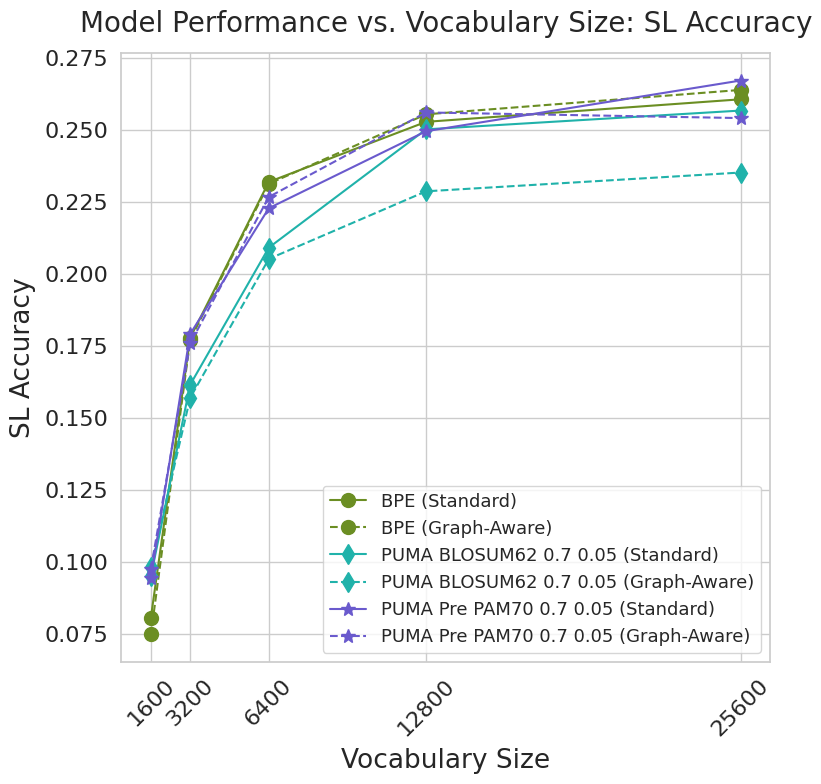

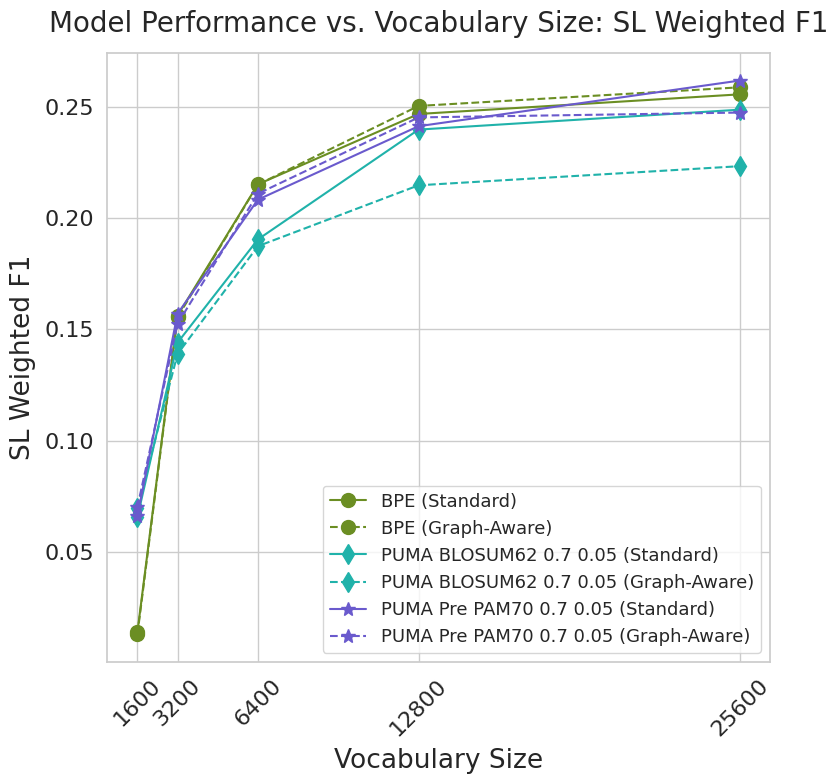

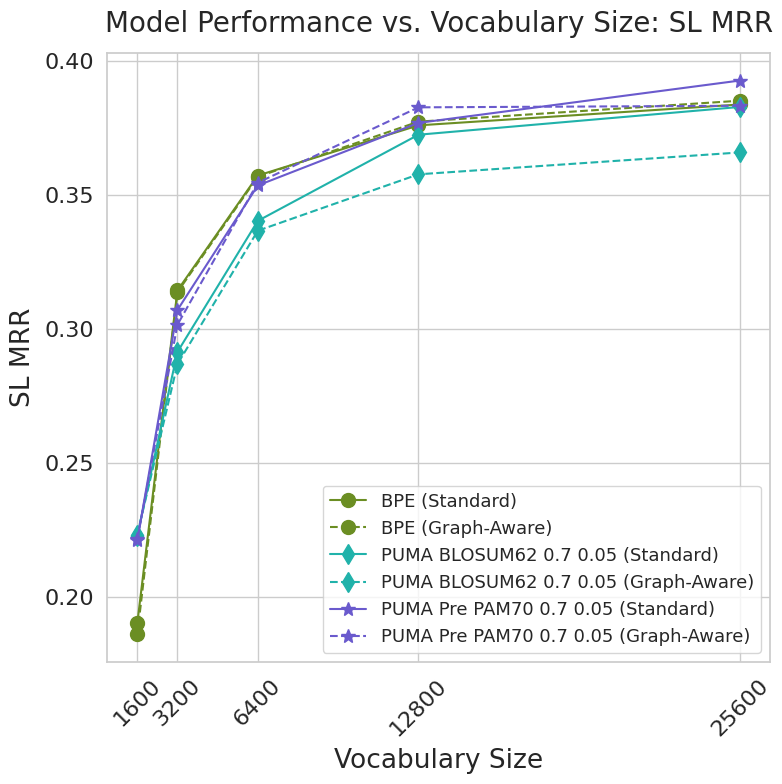

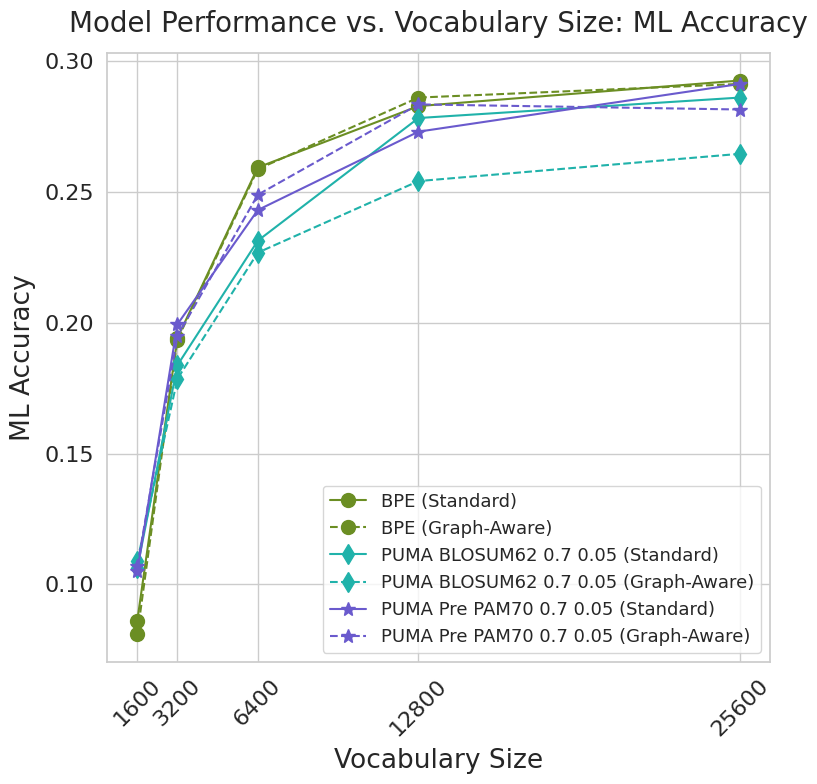

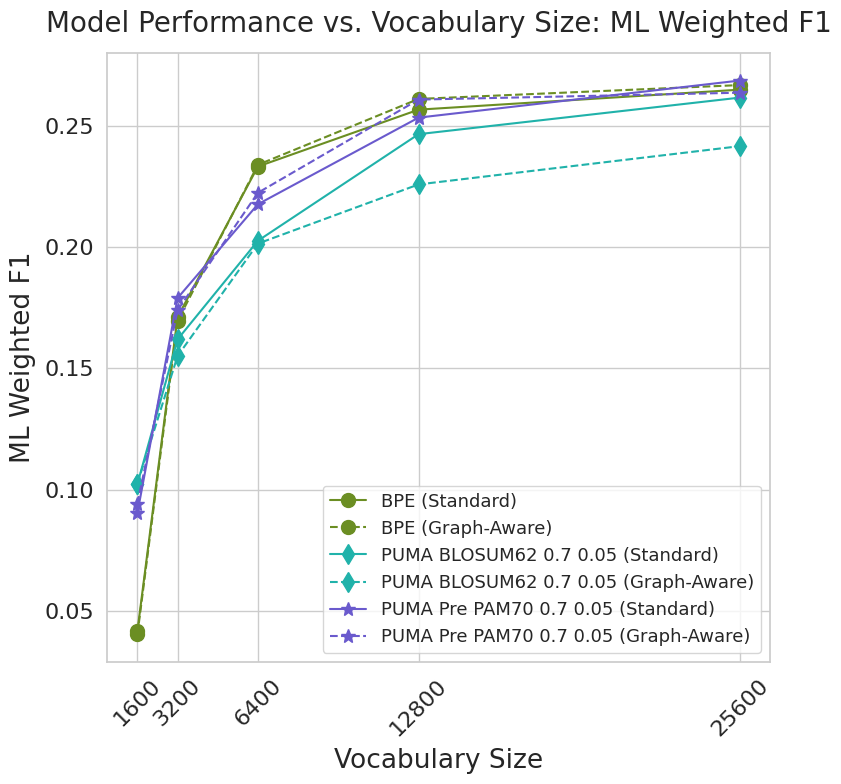

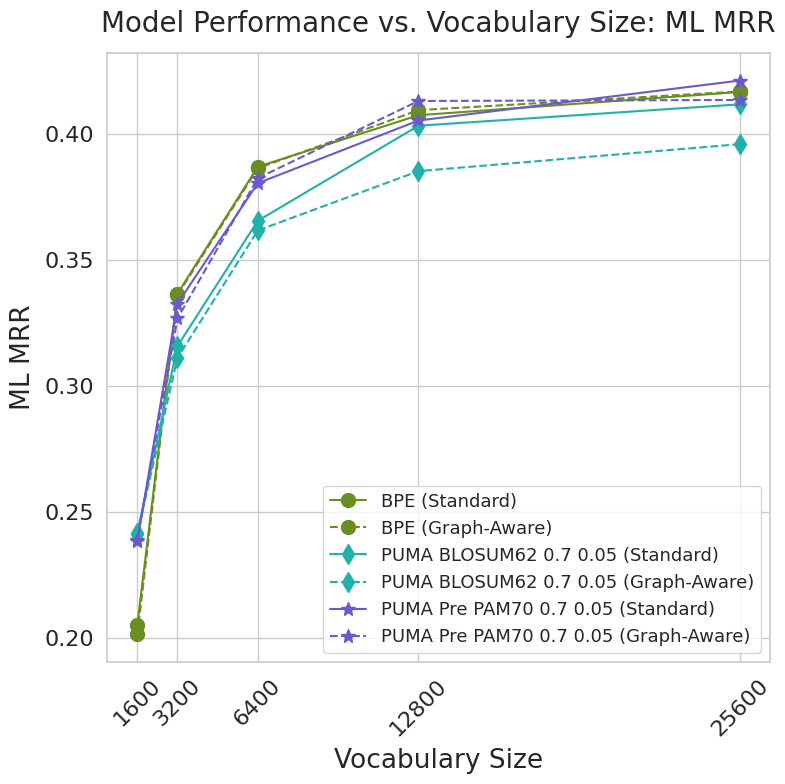

In [56]:
visualize_comparison_results(df_results[['Tokenizer', 'Model', 'SL Accuracy', 'SL Weighted F1', 'SL MRR', 'ML Accuracy', 'ML Weighted F1', 'ML MRR']], methods, methods2names, vocab_sizes)